In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt

# Loading the cleaned dataset we exported in the previous notebook
df = pd.read_csv('../data/cleaned_data.csv')

# Ensure the labels match exactly what we have in the dataframe
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
          'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 
          'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

print(f"Dataset successfully loaded. Total records: {len(df)}")

Dataset successfully loaded. Total records: 112104


In [2]:
# We use GroupShuffleSplit to ensure images from the same patient ID stay together
# This prevents the model from "memorizing" a specific patient's anatomy

# 1. First split: 80% for training, 20% for the rest (Validation + Test)
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(gss.split(df, groups=df['Patient ID']))

train_df = df.iloc[train_idx]
temp_df = df.iloc[temp_idx]

# 2. Second split: Divide the 20% into half for Validation and half for Testing
gss_val = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx, test_idx = next(gss_val.split(temp_df, groups=temp_df['Patient ID']))

valid_df = temp_df.iloc[val_idx]
test_df = temp_df.iloc[test_idx]

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(valid_df)} images")
print(f"Final Test set: {len(test_df)} images")

Training set: 89859 images
Validation set: 10987 images
Final Test set: 11258 images


In [3]:
# Configuring image processing parameters
IMG_SIZE = (224, 224) # Standard input size for most deep learning models
BATCH_SIZE = 16       # Optimized for 4GB VRAM to avoid 'Out of Memory' errors

# Augmentation for Training: helps the model generalize better by seeing varied versions of images
train_idg = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    horizontal_flip=True, 
    rotation_range=15, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, 
    zoom_range=0.1,
    fill_mode='reflect'
)

# For Validation and Testing, we ONLY rescale. No augmentation should be applied here.
test_idg = ImageDataGenerator(rescale=1./255)

In [4]:
# Creating the generators that will feed the neural network

train_gen = train_idg.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',          # The column containing absolute paths
    y_col=labels,          # The list of 14 pathology columns
    class_mode='raw',      # Used for multi-label tasks
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True           # Shuffle only during training
)

valid_gen = test_idg.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col=labels,
    class_mode='raw',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Test generator: we use batch_size=1 for accurate evaluation later
test_gen = test_idg.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col=labels,
    class_mode='raw',
    target_size=IMG_SIZE,
    batch_size=1,
    shuffle=False
)

Found 89859 validated image filenames.
Found 10987 validated image filenames.
Found 11258 validated image filenames.


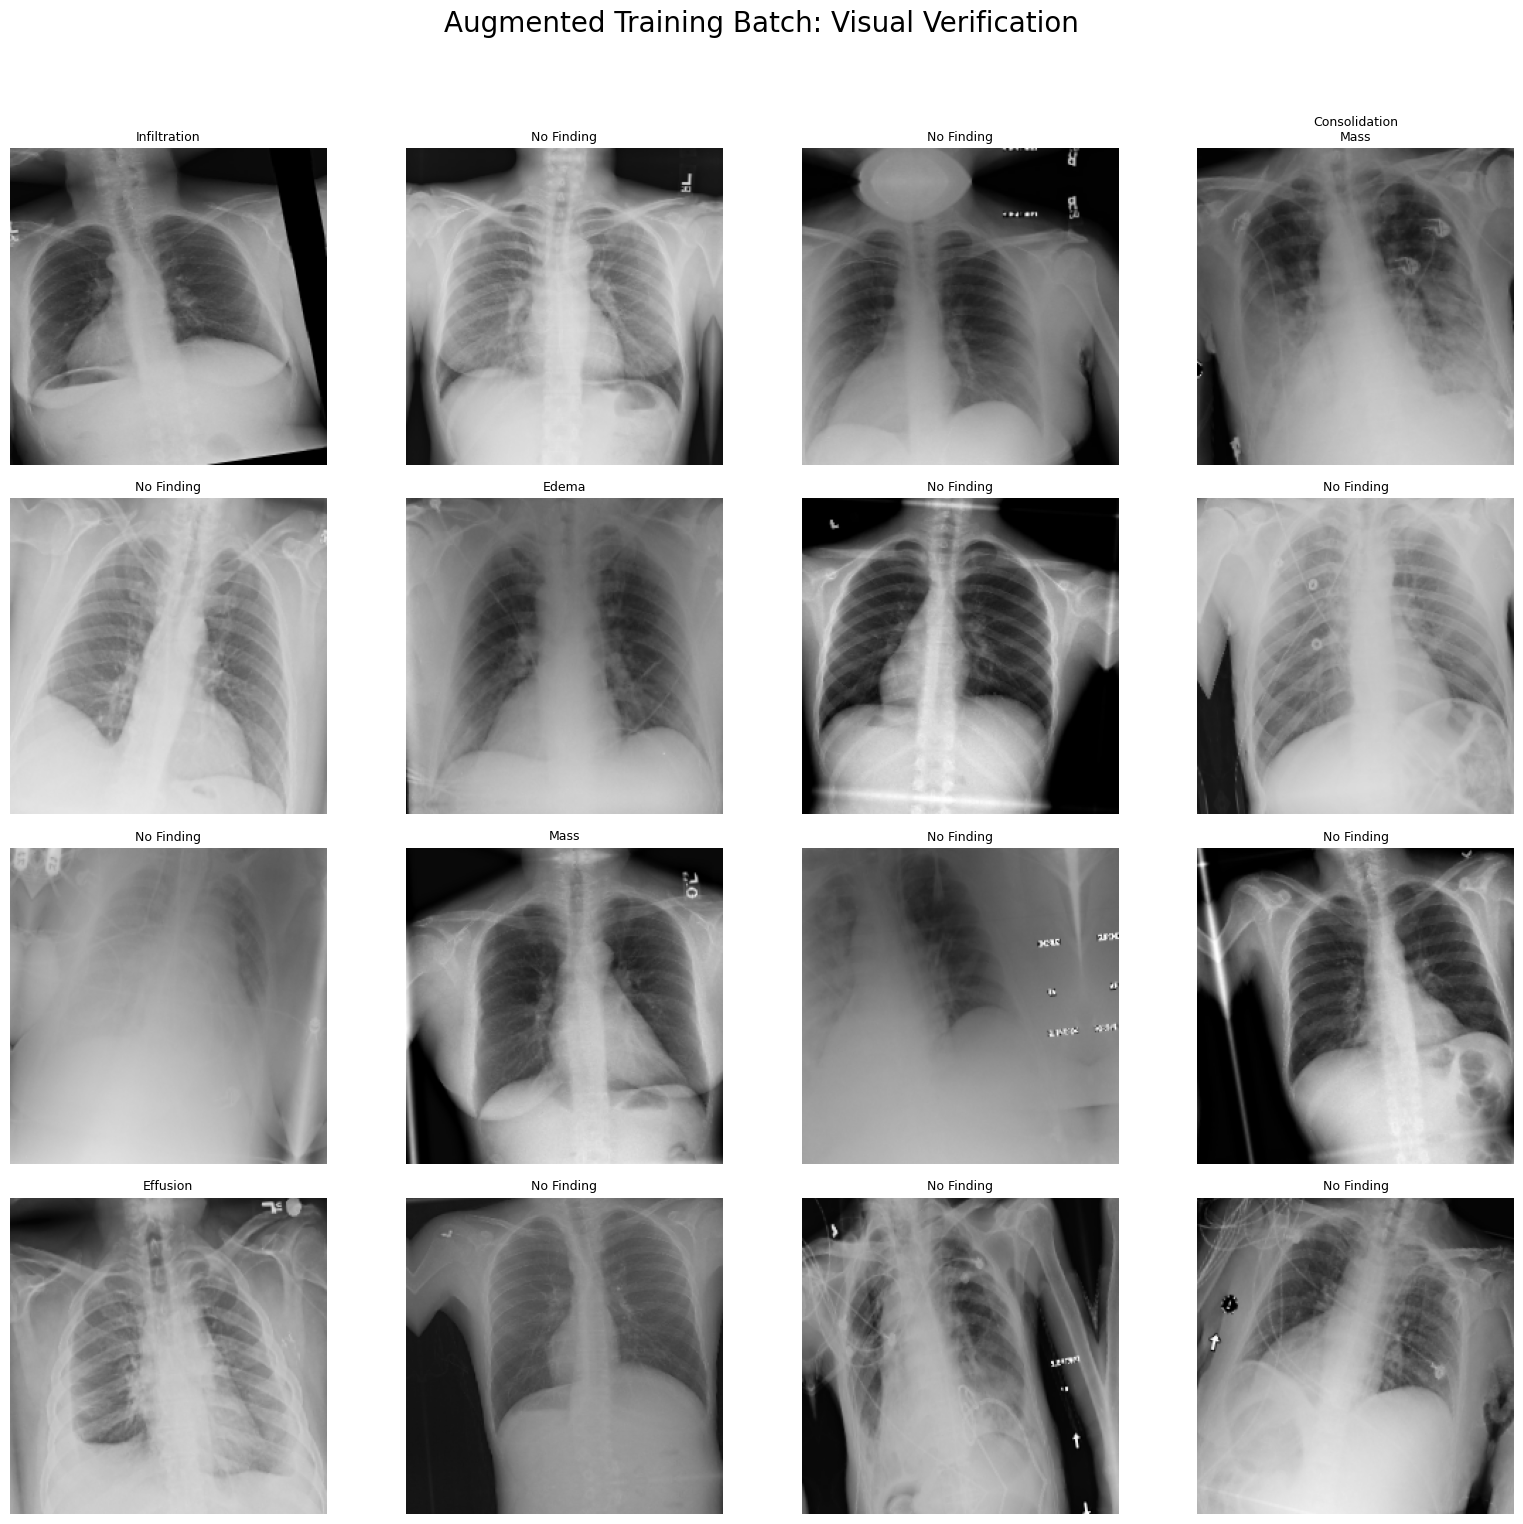

In [5]:
# Let's visualize what the training pipeline is actually producing
t_x, t_y = next(train_gen)

plt.figure(figsize=(16, 16))
for i in range(len(t_x)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(t_x[i])
    # Identify which diseases are present in this specific image
    active_labels = [labels[j] for j, val in enumerate(t_y[i]) if val == 1]
    title_text = "\n".join(active_labels) if active_labels else "No Finding"
    plt.title(title_text, fontsize=9)
    plt.axis('off')

plt.suptitle("Augmented Training Batch: Visual Verification", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()